# The Very Best Model
### Combined warbler acoustic parameters and audio descriptors on gradient boosted trees

In [1]:
import sklearn
import numpy as np
import pandas as pd
import xgboost as xg
import seaborn as sns
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline  

Load both data sets

In [2]:
descriptors_path = '/home/tracek/Data/gender/gender_descriptors.csv'
warbler_path = '/home/tracek/Data/gender/gender_warbler.csv'
seed = 42

params = {'max_depth': 4,
          'n_estimators': 1000,
          'objective': 'binary:logistic',
          'eval_metric': ['auc', 'error'],
          'gamma': 0.1}

test_fraction = 0.1
val_fraction = 0.2

Concatenate the two. Since they were produced on identical data sets and nothing is missing, we can simply sort data by filename and concatenate horizontally - no joins required.

In [3]:
warbler_df = pd.read_csv(warbler_path).sort_values('filename').drop(['filename', 'centroid', 'dfrange'], axis=1)
descriptors_df = pd.read_csv(descriptors_path).sort_values('filename').drop(['filename', 'label'], axis=1)
data = pd.concat([warbler_df, descriptors_df], axis=1)
y = data.pop('label')

### Train - Validation (Development) - Test split
I divide my data into three sets to prevent information leakage when tuning any hyperparameters.

In [4]:
if test_fraction > 0.0:
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_fraction, random_state=seed, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_fraction, random_state=seed, stratify=y_train)
    dtest = xg.DMatrix(X_test, label=y_test)
else:
    X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=val_fraction, random_state=seed, stratify=y)

## Train! 

In [5]:
dtrain = xg.DMatrix(X_train, label=y_train)
dval = xg.DMatrix(X_val, label=y_val)
evallist = [(dval, 'eval'), (dtrain, 'train')]
model = xg.train(params=params, dtrain=dtrain, num_boost_round=200, evals=evallist, early_stopping_rounds=5)

[0]	eval-auc:0.980711	eval-error:0.036509	train-auc:0.980117	train-error:0.036703
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[1]	eval-auc:0.984556	eval-error:0.032722	train-auc:0.984372	train-error:0.032709
[2]	eval-auc:0.987556	eval-error:0.030888	train-auc:0.987744	train-error:0.032398
[3]	eval-auc:0.990196	eval-error:0.030828	train-auc:0.990248	train-error:0.031688
[4]	eval-auc:0.990836	eval-error:0.030651	train-auc:0.990785	train-error:0.030963
[5]	eval-auc:0.991828	eval-error:0.028994	train-auc:0.991743	train-error:0.028788
[6]	eval-auc:0.992379	eval-error:0.028935	train-auc:0.992531	train-error:0.02901
[7]	eval-auc:0.992718	eval-error:0.027337	train-auc:0.992857	train-error:0.027279
[8]	eval-auc:0.993862	eval-error:0.026627	train-auc:0.993813	train-error:0.026584
[9]	eval-auc:0.994133	eval-error:0.025917	train-auc:0.994226	train-error:0.025223
[10]	eval-auc:0.994682	eval-error:0

[98]	eval-auc:0.999389	eval-error:0.007811	train-auc:0.9998	train-error:0.004571
[99]	eval-auc:0.999388	eval-error:0.007811	train-auc:0.999801	train-error:0.004527
[100]	eval-auc:0.999401	eval-error:0.007811	train-auc:0.999808	train-error:0.004335
[101]	eval-auc:0.99939	eval-error:0.007751	train-auc:0.999815	train-error:0.004379
[102]	eval-auc:0.999393	eval-error:0.007811	train-auc:0.99982	train-error:0.004246
[103]	eval-auc:0.999402	eval-error:0.007929	train-auc:0.999825	train-error:0.004157
[104]	eval-auc:0.999412	eval-error:0.007929	train-auc:0.99983	train-error:0.004068
[105]	eval-auc:0.999424	eval-error:0.007811	train-auc:0.999837	train-error:0.004024
[106]	eval-auc:0.999426	eval-error:0.007811	train-auc:0.999842	train-error:0.003905
[107]	eval-auc:0.99943	eval-error:0.007929	train-auc:0.999846	train-error:0.003802
[108]	eval-auc:0.999436	eval-error:0.008047	train-auc:0.999851	train-error:0.003772
[109]	eval-auc:0.999433	eval-error:0.007988	train-auc:0.999853	train-error:0.003772


[197]	eval-auc:0.999564	eval-error:0.007396	train-auc:0.999987	train-error:0.001095
[198]	eval-auc:0.999565	eval-error:0.007278	train-auc:0.999987	train-error:0.00111
[199]	eval-auc:0.999566	eval-error:0.007278	train-auc:0.999988	train-error:0.001095


Looks great, beats the two separately (no surprises here). The model converges significantly faster then warbler alone and only a bit slower than descriptors alone. Yay.

In [6]:
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

In [7]:
r = metrics.classification_report(y_true=y_test, y_pred=y_pred)
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

In [8]:
print(r)

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      7882
          1       0.98      0.97      0.98      1507

avg / total       0.99      0.99      0.99      9389



In [9]:
print('Accuracy: ', acc)

Accuracy:  0.993183512621


### Excellent!
The score on test set beats significantly the warbler and improves over descriptors alone. **It should be highlighted that the presented metrics have been achieved on test set**. The latter is a novel data set - it has not been used for any sort of tuning.

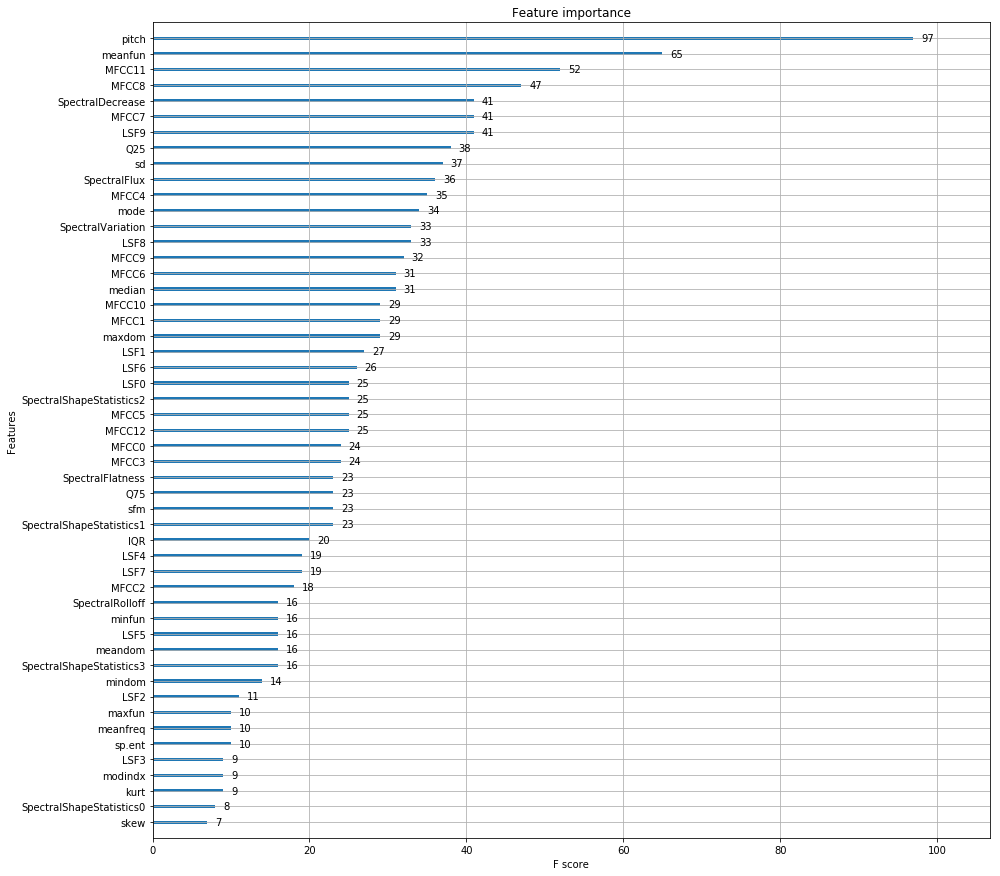

In [ ]:
model.feature_names = [name.replace(' ', '') for name in model.feature_names]
fig, ax = plt.subplots(figsize=(15, 15))
xg.plot_importance(model, ax)

What is striking is that the pitch I am calculating (with aubio!) beats what warbleR delivers. Also, somewhat less surprisingly, mel-frequencies cepstrum coefficients are doing amazingly well. Curious, since aggregated I did not think they will be THAT informative (at least some). On the other hand, these are meant to capture voice characteristic.

Let's see how these features correlate with each other.

In [ ]:
data_corr = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(data_corr, 
            xticklabels=data_corr.columns.values,
            yticklabels=data_corr.columns.values,
            linewidths=0.2,
            vmax=1.0,
            square=True,
            cmap=plt.cm.viridis,
            linecolor='white',
            annot=True)
plt.savefig('combined_correlation.png')

Interestingly, we don't get that high correlation on features that were computed from both approaches, like e.g. spectral flatness. 

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('Confusion matrix for audio descriptors (Yaafe)')
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', square=True,
            xticklabels=['Male - predicted', 'Female - predicted'], yticklabels=['Male - true', 'Female - true'])

## Discussion of errors
The mistakes are truly marginal. Model does not represent any strong bias. Frankly, I would easily confuse 1% of time a person on a phone. On top of that, the data set contains also recording of youth, meaning also people before voice change - or ongoing change. This will also confuse the model. Last, but not least...

# Metadata lies! 
(mo surprises here)
Here are two examples of incorrectly labelled recordings: *male* labelled as *female*:
- Anniepoo-20140308-bft - male
- abc-20091120-mfr - male